# Visualization of experiments

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pickle as pkl

**Plotting utils**

In [3]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12

In [36]:
def plot_training_curves(results_df, metric_name, ylabel, title, filename=None, figsize=(14, 10)):
    """
    Plot training and validation curves across folds for a given metric.
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame containing experiment results with columns: fold, experiment, epoch, train_metric, val_metric
    metric_name : str
        Name of the metric column (e.g., 'loss', 'dice')
    """
    experiments = results_df['experiment'].unique()
    n_folds = sorted(results_df['fold'].unique())
    has_train_data = results_df[f"train_{metric_name}"].notnull().any()
    num_rows = 2 if has_train_data else 1

    fig, axes = plt.subplots(num_rows, len(n_folds), figsize=figsize, sharex=True)
    
    axes = axes.reshape(num_rows, len(n_folds))
    
    for idx, fold in enumerate(n_folds):
        fold_data = results_df[results_df['fold'] == fold]
        
        ax_val = axes[0, idx]
        for exp in experiments:
            exp_data = fold_data[fold_data['experiment'] == exp]
            if not exp_data.empty:
                ax_val.plot(exp_data['epoch'], exp_data[f'val_{metric_name}'], 
                           label=exp, linestyle='--', alpha=0.8, linewidth=2)
        
        ax_val.set_xlabel('Epoch', fontsize=12)
        ax_val.set_ylabel(f'Validation {ylabel}' if idx == 0 else '', fontsize=12)
        if idx == 0:
            ax_val.legend(fontsize=10, loc='best')
        ax_val.grid(True, alpha=0.3)

        if  has_train_data:
            ax_train = axes[1, idx]
            for exp in experiments:
                exp_data = fold_data[fold_data['experiment'] == exp]
                if not exp_data.empty:
                    ax_train.plot(exp_data['epoch'], exp_data[f'train_{metric_name}'], 
                                label=exp, linestyle='-', alpha=0.8, linewidth=2)
            
            ax_train.set_ylabel(f'Training {ylabel}' if idx == 0 else '', fontsize=12)
            ax_train.set_title(f'Fold {fold}', fontsize=14, fontweight='bold')
            if idx == 0:
                ax_train.legend(fontsize=10, loc='best')
            ax_train.grid(True, alpha=0.3)
    
    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    plt.show()


def plot_fold_comparison_boxplot(results_df, metric_name, ylabel, title, filename, figsize=(10, 6)):
    """
    Plot boxplot comparing metric distribution across folds for each experiment.
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame containing best epoch results per fold
    metric_name : str
        Name of the metric column (e.g., 'val_dice')
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    experiments = sorted(results_df['experiment'].unique())
    data_to_plot = [results_df[results_df['experiment'] == exp][metric_name].values 
                    for exp in experiments]
    
    bp = ax.boxplot(data_to_plot, labels=experiments, patch_artist=True)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'][:len(experiments)]
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Experiment', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    plt.show()

def print_statistical_summary(configs, all_results):
    print("=" * 80)
    print("STATISTICAL SUMMARY")
    print("=" * 80)

    best_config = None
    best_avg_dice = 0

    for config in configs:
        matching = [r for r in all_results if r['description'] == config]
        avg_dice = np.mean([r['best_dice'] for r in matching])
        std_dice = np.std([r['best_dice'] for r in matching])
        
        print(f"\n{config}:")
        print(f"  Average Dice: {avg_dice:.4f} ± {std_dice:.4f}")
        for i, result in enumerate(matching):
            print(f"  Fold {result['fold']}: {result['best_dice']:.4f} (epoch {result['best_epoch']})")
        
        if avg_dice > best_avg_dice:
            best_avg_dice = avg_dice
            best_config = config

    print("\n" + "=" * 80)
    print(f"   BEST CONFIGURATION: {best_config}")
    print(f"   Average Dice Score: {best_avg_dice:.4f}")
    print("=" * 80)

    # configs[0] is baseline
    baseline = [r for r in all_results if configs[0] in r['description']]
    baseline_avg = np.mean([r['best_dice'] for r in baseline])

    for config in configs[1:]:
        matching = [r for r in all_results if r['description'] == config]
        avg_dice = np.mean([r['best_dice'] for r in matching])
        improvement = ((avg_dice - baseline_avg) / baseline_avg) * 100
        print(f"\n{config}:")
        print(f"  Improvement over baseline: {improvement:+.2f}%")

## 1. Loss Functions Experiment

In [5]:
results_path = "criterion_experiment_results.pkl"
with open(results_path, "rb") as f:
    all_results = pkl.load(f)

print(f"Loaded {len(all_results)} experiment results")
print("\nExperiment configurations:")
for i, result in enumerate(all_results):
    print(f"{i+1}. {result['description']} (Fold {result['fold']})")

Loaded 8 experiment results

Experiment configurations:
1. FT=0.0, No Class Weights (Fold 1)
2. FT=0.0, No Class Weights (Fold 2)
3. FT=0.0, With Class Weights (Fold 1)
4. FT=0.0, With Class Weights (Fold 2)
5. FT=0.2, No Class Weights (Fold 1)
6. FT=0.2, No Class Weights (Fold 2)
7. FT=0.2, With Class Weights (Fold 1)
8. FT=0.2, With Class Weights (Fold 2)


In [6]:
# construct the dataframes
criterion_data = []

for result in all_results:
    n_epochs = len(result['train_losses'])
    for epoch in range(n_epochs):
        criterion_data.append({
            'experiment': result['description'],
            'fold': result['fold'],
            'epoch': epoch + 1,
            'train_loss': result['train_losses'][epoch],
            'val_loss': result['val_losses'][epoch],
            'train_dice': None,  # Not tracked separately in this experiment
            'val_dice': result['val_dices'][epoch]
        })

criterion_df = pd.DataFrame(criterion_data)

criterion_best = []
for result in all_results:
    criterion_best.append({
        'experiment': result['description'],
        'fold': result['fold'],
        'val_dice': result['best_dice'],
        'best_epoch': result['best_epoch'],
        'final_train_loss': result['train_losses'][-1],
        'final_val_loss': result['val_losses'][-1]
    })

criterion_best_df = pd.DataFrame(criterion_best)

criterion_summary = criterion_best_df.groupby('experiment').agg({
    'val_dice': ['mean', 'std'],
    'best_epoch': 'mean',
    'final_train_loss': 'mean',
    'final_val_loss': 'mean'
}).reset_index()

criterion_summary.columns = ['experiment', 'val_dice_mean', 'val_dice_std', 'avg_best_epoch', 
                              'avg_train_loss', 'avg_val_loss']

print("=" * 80)
print("CRITERION EXPERIMENT SUMMARY")
print("=" * 80)
print("\nSummary Statistics:")
print(criterion_summary.to_string(index=False))

print("\n" + "=" * 80)
print("DETAILED RESULTS BY FOLD")
print("=" * 80)
print(criterion_best_df.to_string(index=False))

CRITERION EXPERIMENT SUMMARY

Summary Statistics:
                experiment  val_dice_mean  val_dice_std  avg_best_epoch  avg_train_loss  avg_val_loss
  FT=0.0, No Class Weights       0.465279      0.034089            29.0        0.431813      0.556158
FT=0.0, With Class Weights       0.462232      0.040859            23.5        0.487455      0.774164
  FT=0.2, No Class Weights       0.478847      0.060984            25.0        0.557993      0.704219
FT=0.2, With Class Weights       0.464400      0.041571            24.0        0.614858      0.902962

DETAILED RESULTS BY FOLD
                experiment  fold  val_dice  best_epoch  final_train_loss  final_val_loss
  FT=0.0, No Class Weights     1  0.441175          30          0.444578        0.592642
  FT=0.0, No Class Weights     2  0.489384          28          0.419048        0.519674
FT=0.0, With Class Weights     1  0.433340          26          0.467200        0.894417
FT=0.0, With Class Weights     2  0.491124          21    

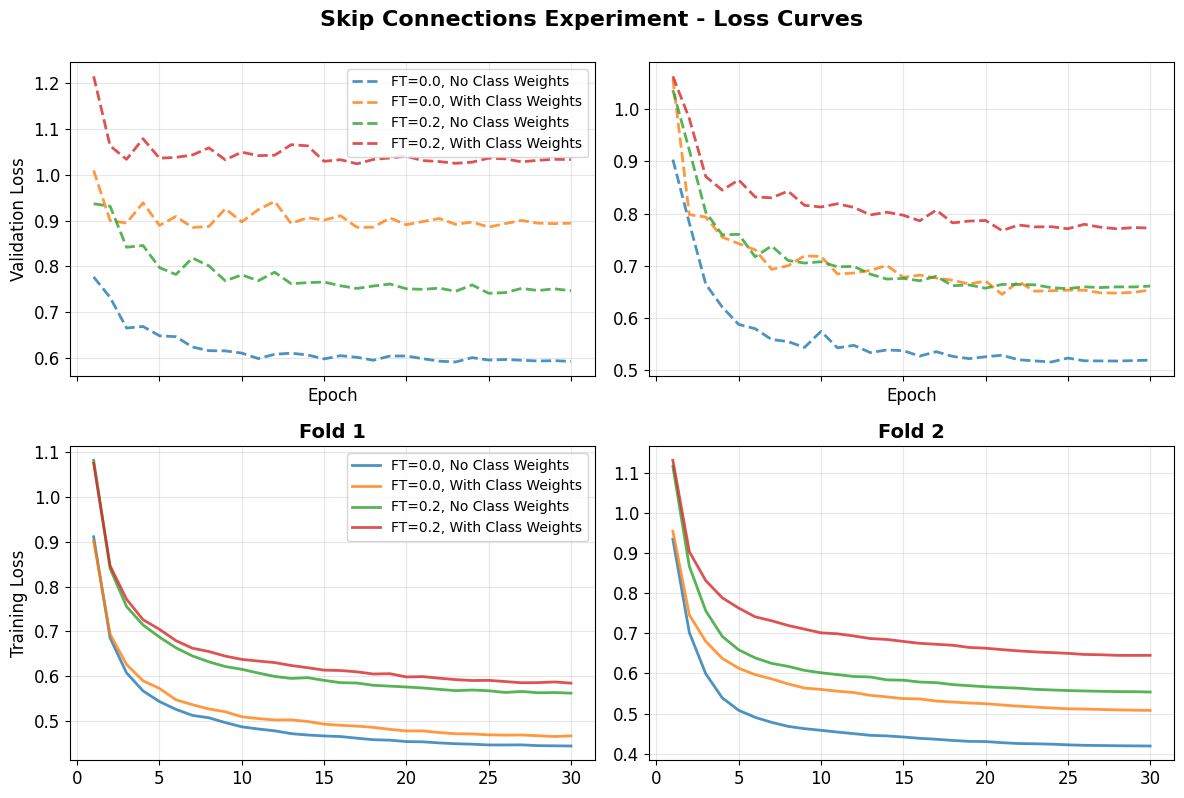

In [20]:
# Validation Loss Curves Across Folds
plot_training_curves(
    criterion_df,
    metric_name='loss',
    ylabel='Loss',
    title='Loss Function Experiment - Loss Curves',
    figsize=(12, 8)
)

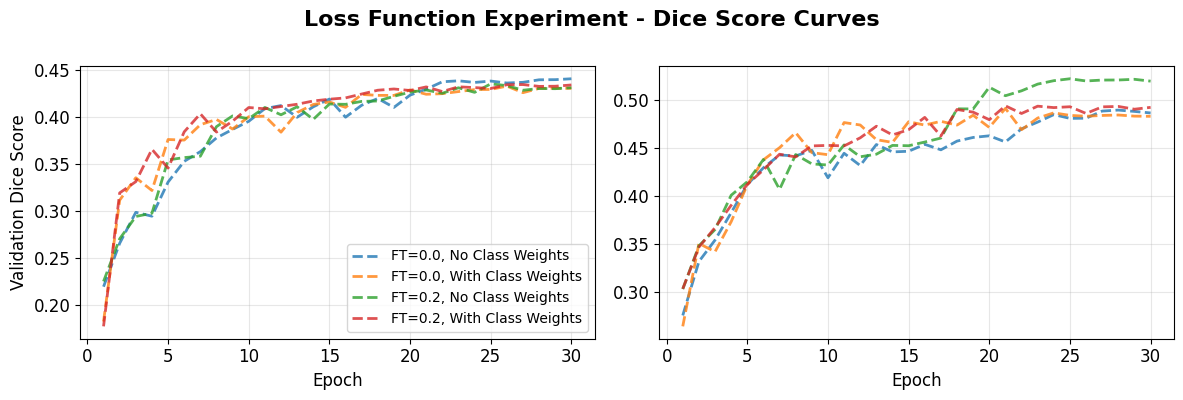

In [25]:
# Validation Dice Curves Across Folds
plot_training_curves(
    criterion_df,
    metric_name='dice',
    ylabel='Dice Score',
    title='Loss Function Experiment - Dice Score Curves',
    figsize=(12, 4)
)

**Statistical Summary**

In [24]:
configs = ['FT=0.0, No Class Weights', 'FT=0.0, With Class Weights', 'FT=0.2, No Class Weights', 'FT=0.2, With Class Weights']
print_statistical_summary(configs, all_results)

STATISTICAL SUMMARY

FT=0.0, No Class Weights:
  Average Dice: 0.4653 ± 0.0241
  Fold 1: 0.4412 (epoch 30)
  Fold 2: 0.4894 (epoch 28)

FT=0.0, With Class Weights:
  Average Dice: 0.4622 ± 0.0289
  Fold 1: 0.4333 (epoch 26)
  Fold 2: 0.4911 (epoch 21)

FT=0.2, No Class Weights:
  Average Dice: 0.4788 ± 0.0431
  Fold 1: 0.4357 (epoch 25)
  Fold 2: 0.5220 (epoch 25)

FT=0.2, With Class Weights:
  Average Dice: 0.4644 ± 0.0294
  Fold 1: 0.4350 (epoch 27)
  Fold 2: 0.4938 (epoch 21)

   BEST CONFIGURATION: FT=0.2, No Class Weights
   Average Dice Score: 0.4788

FT=0.0, With Class Weights:
  Improvement over baseline: -0.65%

FT=0.2, No Class Weights:
  Improvement over baseline: +2.92%

FT=0.2, With Class Weights:
  Improvement over baseline: -0.19%


## 2. Skip Connections and Modality Experiment

Here we compare including the original skip connections from CellVit decoder. They use skip connections from different layers of encoder, and connect it to the decoder. We also compare using only Spatial Proteomics data to H&E + SP data.

In [26]:
# Load skipconn experiment results
with open('skipconn_experiment_results.pkl', 'rb') as f:
    skipconn_results = pkl.load(f)

print(f"Loaded {len(skipconn_results)} experiment results")
print(f"\nExperiment configurations:")
for i, result in enumerate(skipconn_results[:4], 1):
    print(f"  {i}. {result['description']}")

Loaded 8 experiment results

Experiment configurations:
  1. SP+HE with Skip Connections
  2. SP+HE with Skip Connections
  3. SP+HE without Skip Connections
  4. SP+HE without Skip Connections


In [27]:
# Convert skipconn results to DataFrame format for plotting
skipconn_data = []

for result in skipconn_results:
    n_epochs = len(result['train_losses'])
    for epoch in range(n_epochs):
        skipconn_data.append({
            'experiment': result['description'],
            'modality': result['modality'],
            'use_skip': result['use_skip'],
            'fold': result['fold'],
            'epoch': epoch + 1,
            'train_loss': result['train_losses'][epoch],
            'val_loss': result['val_losses'][epoch],
            'train_dice': None,  # Not tracked separately in this experiment
            'val_dice': result['val_dices'][epoch]
        })

skipconn_df = pd.DataFrame(skipconn_data)

# Create summary with best results per configuration
skipconn_best = []
for result in skipconn_results:
    skipconn_best.append({
        'experiment': result['description'],
        'modality': result['modality'],
        'use_skip': result['use_skip'],
        'fold': result['fold'],
        'val_dice': result['best_dice'],
        'best_epoch': result['best_epoch']
    })

skipconn_best_df = pd.DataFrame(skipconn_best)

# Aggregate across folds
skipconn_summary = skipconn_best_df.groupby('experiment').agg({
    'val_dice': ['mean', 'std'],
    'best_epoch': 'mean'
}).reset_index()

skipconn_summary.columns = ['experiment', 'val_dice_mean', 'val_dice_std', 'avg_best_epoch']

print("\nSummary Statistics:")
print(skipconn_summary.to_string(index=False))


Summary Statistics:
                      experiment  val_dice_mean  val_dice_std  avg_best_epoch
     SP+HE with Skip Connections       0.479054      0.074148            25.5
  SP+HE without Skip Connections       0.442082      0.042382            27.0
   SP-only with Skip Connections       0.478714      0.069633            21.5
SP-only without Skip Connections       0.433018      0.041672            26.0


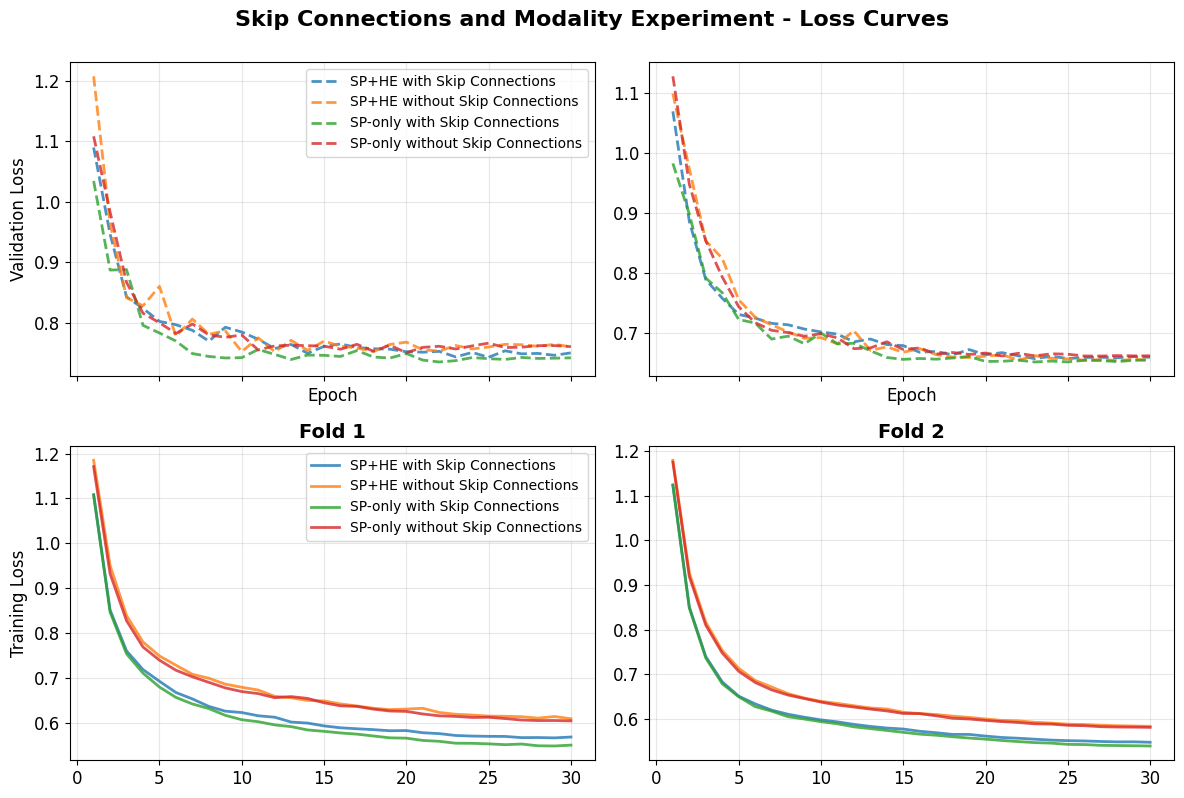

In [29]:
# Validation Loss Curves Across Folds
plot_training_curves(
    skipconn_df,
    metric_name='loss',
    ylabel='Loss',
    title='Skip Connections and Modality Experiment - Loss Curves',
    figsize=(12, 8)
)

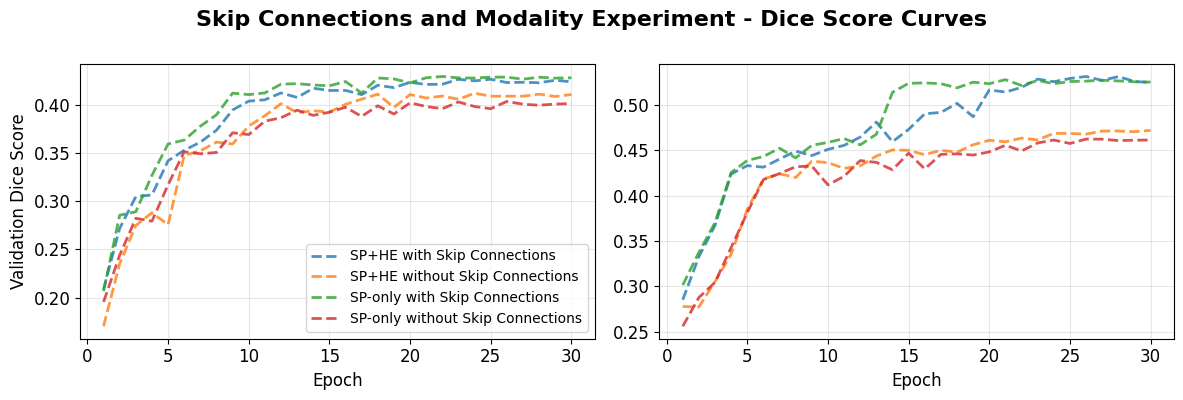

In [30]:
# Validation Dice Curves Across Folds
plot_training_curves(
    skipconn_df,
    metric_name='dice',
    ylabel='Dice Score',
    title='Skip Connections and Modality Experiment - Dice Score Curves',
    figsize=(12, 4)
)

In [37]:
configs = ["SP-only without Skip Connections", "SP-only with Skip Connections", "SP+HE without Skip Connections", "SP+HE with Skip Connections"]
print_statistical_summary(configs, skipconn_results)

STATISTICAL SUMMARY

SP-only without Skip Connections:
  Average Dice: 0.4330 ± 0.0295
  Fold 1: 0.4036 (epoch 26)
  Fold 2: 0.4625 (epoch 26)

SP-only with Skip Connections:
  Average Dice: 0.4787 ± 0.0492
  Fold 1: 0.4295 (epoch 22)
  Fold 2: 0.5280 (epoch 21)

SP+HE without Skip Connections:
  Average Dice: 0.4421 ± 0.0300
  Fold 1: 0.4121 (epoch 24)
  Fold 2: 0.4721 (epoch 30)

SP+HE with Skip Connections:
  Average Dice: 0.4791 ± 0.0524
  Fold 1: 0.4266 (epoch 25)
  Fold 2: 0.5315 (epoch 26)

   BEST CONFIGURATION: SP+HE with Skip Connections
   Average Dice Score: 0.4791

SP-only with Skip Connections:
  Improvement over baseline: +10.55%

SP+HE without Skip Connections:
  Improvement over baseline: +2.09%

SP+HE with Skip Connections:
  Improvement over baseline: +10.63%


## 3. Oversampling Experiment



In [38]:
with open('oversampling_experiment_results.pkl', 'rb') as f:
    oversampling_results = pkl.load(f)

print(f"Loaded {len(oversampling_results)} experiment results")
print(f"\nExperiment configurations:")
for i, result in enumerate(oversampling_results, 1):
    print(f"  {i}. {result['description']} fold {result['fold']}")

Loaded 6 experiment results

Experiment configurations:
  1. Cell Oversampling gamma_s=0.0 fold 1
  2. Cell Oversampling gamma_s=0.0 fold 2
  3. Cell Oversampling gamma_s=0.45 fold 1
  4. Cell Oversampling gamma_s=0.45 fold 2
  5. Cell Oversampling gamma_s=0.85 fold 1
  6. Cell Oversampling gamma_s=0.85 fold 2


In [39]:
oversampling_data = []

for result in oversampling_results:
    n_epochs = len(result['train_losses'])
    for epoch in range(n_epochs):
        oversampling_data.append({
            'experiment': result['description'],
            'fold': result['fold'],
            'epoch': epoch + 1,
            'train_loss': result['train_losses'][epoch],
            'val_loss': result['val_losses'][epoch],
            'train_dice': None,  # Not tracked separately in this experiment
            'val_dice': result['val_dices'][epoch]
        })

oversampling_df = pd.DataFrame(oversampling_data)

# Create summary with best results per configuration
oversampling_best = []
for result in oversampling_results:
    oversampling_best.append({
        'experiment': result['description'],
        'fold': result['fold'],
        'val_dice': result['best_dice'],
        'best_epoch': result['best_epoch']
    })

oversampling_best_df = pd.DataFrame(oversampling_best)

# Aggregate across folds
oversampling_summary = oversampling_best_df.groupby('experiment').agg({
    'val_dice': ['mean', 'std'],
    'best_epoch': 'mean'
}).reset_index()

oversampling_summary.columns = ['experiment', 'val_dice_mean', 'val_dice_std', 'avg_best_epoch']

print("=" * 80)
print("OVERSAMPLING EXPERIMENT SUMMARY")
print("=" * 80)
print("\nSummary Statistics:")
print(oversampling_summary.to_string(index=False))

print("\n" + "=" * 80)
print("DETAILED RESULTS BY FOLD")
print("=" * 80)
print(oversampling_best_df.to_string(index=False))

OVERSAMPLING EXPERIMENT SUMMARY

Summary Statistics:
                    experiment  val_dice_mean  val_dice_std  avg_best_epoch
 Cell Oversampling gamma_s=0.0       0.479847      0.062405            24.5
Cell Oversampling gamma_s=0.45       0.474330      0.071890            25.5
Cell Oversampling gamma_s=0.85       0.493029      0.077781            20.0

DETAILED RESULTS BY FOLD
                    experiment  fold  val_dice  best_epoch
 Cell Oversampling gamma_s=0.0     1  0.435720          26
 Cell Oversampling gamma_s=0.0     2  0.523974          23
Cell Oversampling gamma_s=0.45     1  0.423496          25
Cell Oversampling gamma_s=0.45     2  0.525165          26
Cell Oversampling gamma_s=0.85     1  0.438030          23
Cell Oversampling gamma_s=0.85     2  0.548029          17


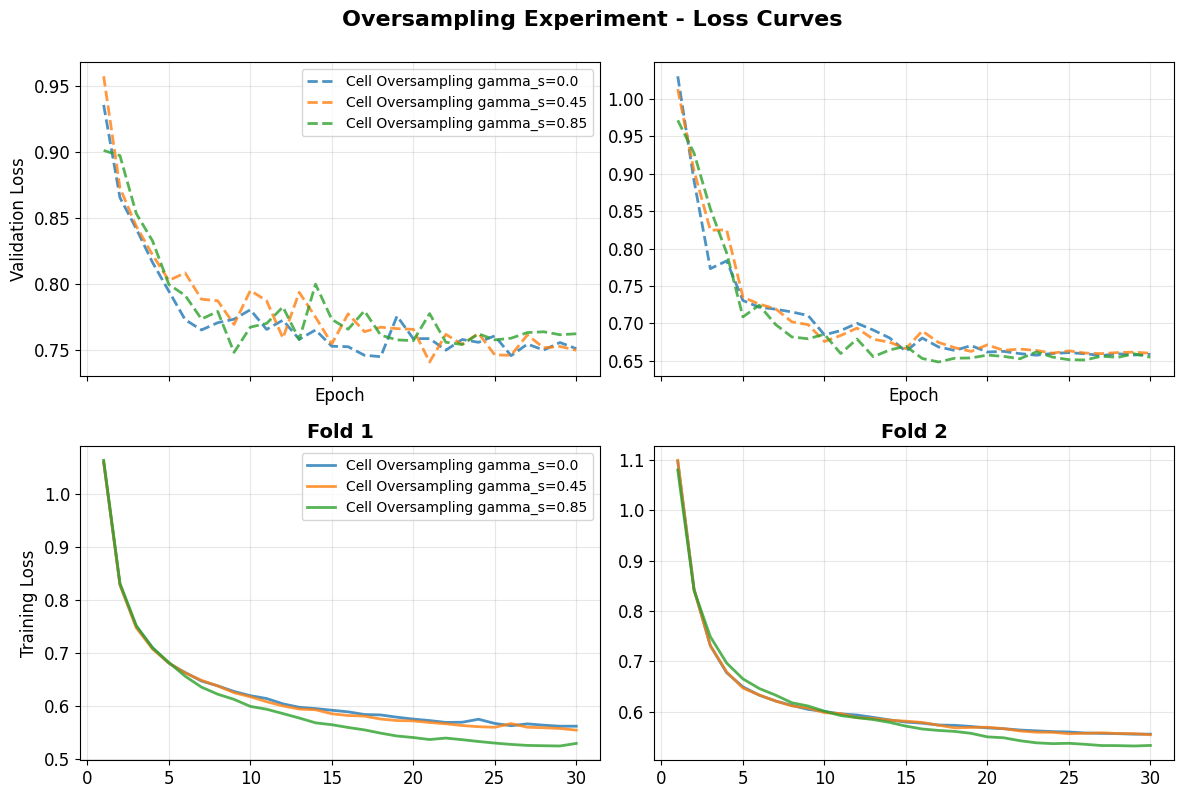

In [41]:
# Validation Loss Curves Across Folds
plot_training_curves(
    oversampling_df,
    metric_name='loss',
    ylabel='Loss',
    title='Oversampling Experiment - Loss Curves',
    figsize=(12, 8)
)

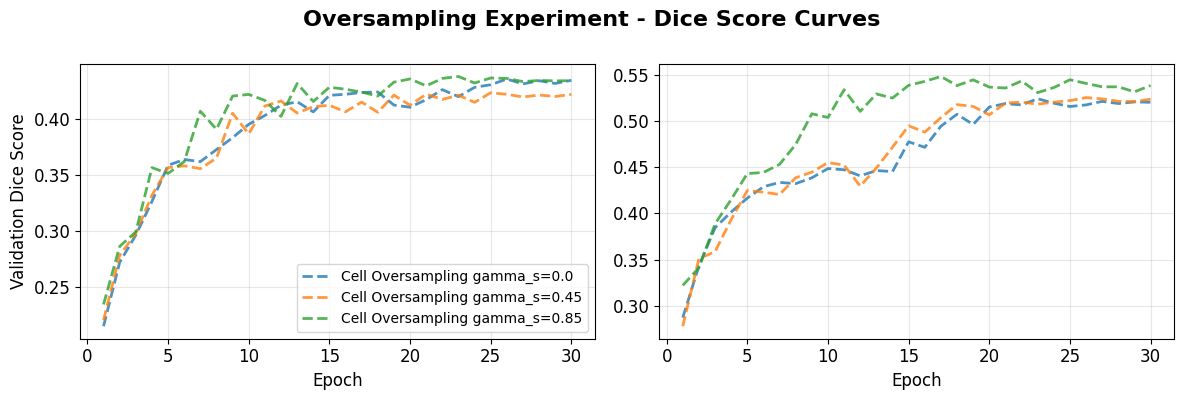

In [43]:
# Validation Loss Curves Across Folds
plot_training_curves(
    oversampling_df,
    metric_name='dice',
    ylabel='Dice Score',
    title='Oversampling Experiment - Dice Score Curves',
    figsize=(12, 4)
)

In [45]:
configs = ["Cell Oversampling gamma_s=0.0", "Cell Oversampling gamma_s=0.45", "Cell Oversampling gamma_s=0.85"]
print_statistical_summary(configs, oversampling_results)

STATISTICAL SUMMARY

Cell Oversampling gamma_s=0.0:
  Average Dice: 0.4798 ± 0.0441
  Fold 1: 0.4357 (epoch 26)
  Fold 2: 0.5240 (epoch 23)

Cell Oversampling gamma_s=0.45:
  Average Dice: 0.4743 ± 0.0508
  Fold 1: 0.4235 (epoch 25)
  Fold 2: 0.5252 (epoch 26)

Cell Oversampling gamma_s=0.85:
  Average Dice: 0.4930 ± 0.0550
  Fold 1: 0.4380 (epoch 23)
  Fold 2: 0.5480 (epoch 17)

   BEST CONFIGURATION: Cell Oversampling gamma_s=0.85
   Average Dice Score: 0.4930

Cell Oversampling gamma_s=0.45:
  Improvement over baseline: -1.15%

Cell Oversampling gamma_s=0.85:
  Improvement over baseline: +2.75%


## 4. Augmentation Experiment

In [46]:
with open('augmentation_experiment_results.pkl', 'rb') as f:
    augmentation_results = pkl.load(f)

print(f"Loaded {len(augmentation_results)} experiment results")
print(f"\nExperiment configurations:")
for i, result in enumerate(augmentation_results, 1):
    print(f"  {i}. {result['description']} fold {result['fold']}")

Loaded 6 experiment results

Experiment configurations:
  1. With Augmentation fold 1
  2. No Augmentation fold 1
  3. With Augmentation fold 2
  4. No Augmentation fold 2
  5. With Augmentation fold 3
  6. No Augmentation fold 3


In [47]:
augmentation_data = []

for result in augmentation_results:
    n_epochs = len(result['train_losses'])
    for epoch in range(n_epochs):
        augmentation_data.append({
            'experiment': result['description'],
            'fold': result['fold'],
            'epoch': epoch + 1,
            'train_loss': result['train_losses'][epoch],
            'val_loss': result['val_losses'][epoch],
            'train_dice': None,  # Not tracked separately in this experiment
            'val_dice': result['val_dices'][epoch]
        })

augmentation_df = pd.DataFrame(augmentation_data)

# Create summary with best results per configuration
augmentation_best = []
for result in augmentation_results:
    augmentation_best.append({
        'experiment': result['description'],
        'fold': result['fold'],
        'val_dice': result['best_dice'],
        'best_epoch': result['best_epoch']
    })

augmentation_best_df = pd.DataFrame(augmentation_best)

# Aggregate across folds
augmentation_summary = augmentation_best_df.groupby('experiment').agg({
    'val_dice': ['mean', 'std'],
    'best_epoch': 'mean'
}).reset_index()

augmentation_summary.columns = ['experiment', 'val_dice_mean', 'val_dice_std', 'avg_best_epoch']

print("=" * 80)
print("AUGMENTATION EXPERIMENT SUMMARY")
print("=" * 80)
print("\nSummary Statistics:")
print(augmentation_summary.to_string(index=False))

print("\n" + "=" * 80)
print("DETAILED RESULTS BY FOLD")
print("=" * 80)
print(augmentation_best_df.to_string(index=False))

AUGMENTATION EXPERIMENT SUMMARY

Summary Statistics:
       experiment  val_dice_mean  val_dice_std  avg_best_epoch
  No Augmentation       0.549087      0.027707       36.000000
With Augmentation       0.560370      0.030446       45.333333

DETAILED RESULTS BY FOLD
       experiment  fold  val_dice  best_epoch
With Augmentation     1  0.594704          46
  No Augmentation     1  0.581065          34
With Augmentation     2  0.549752          46
  No Augmentation     2  0.533959          35
With Augmentation     3  0.536655          44
  No Augmentation     3  0.532238          39


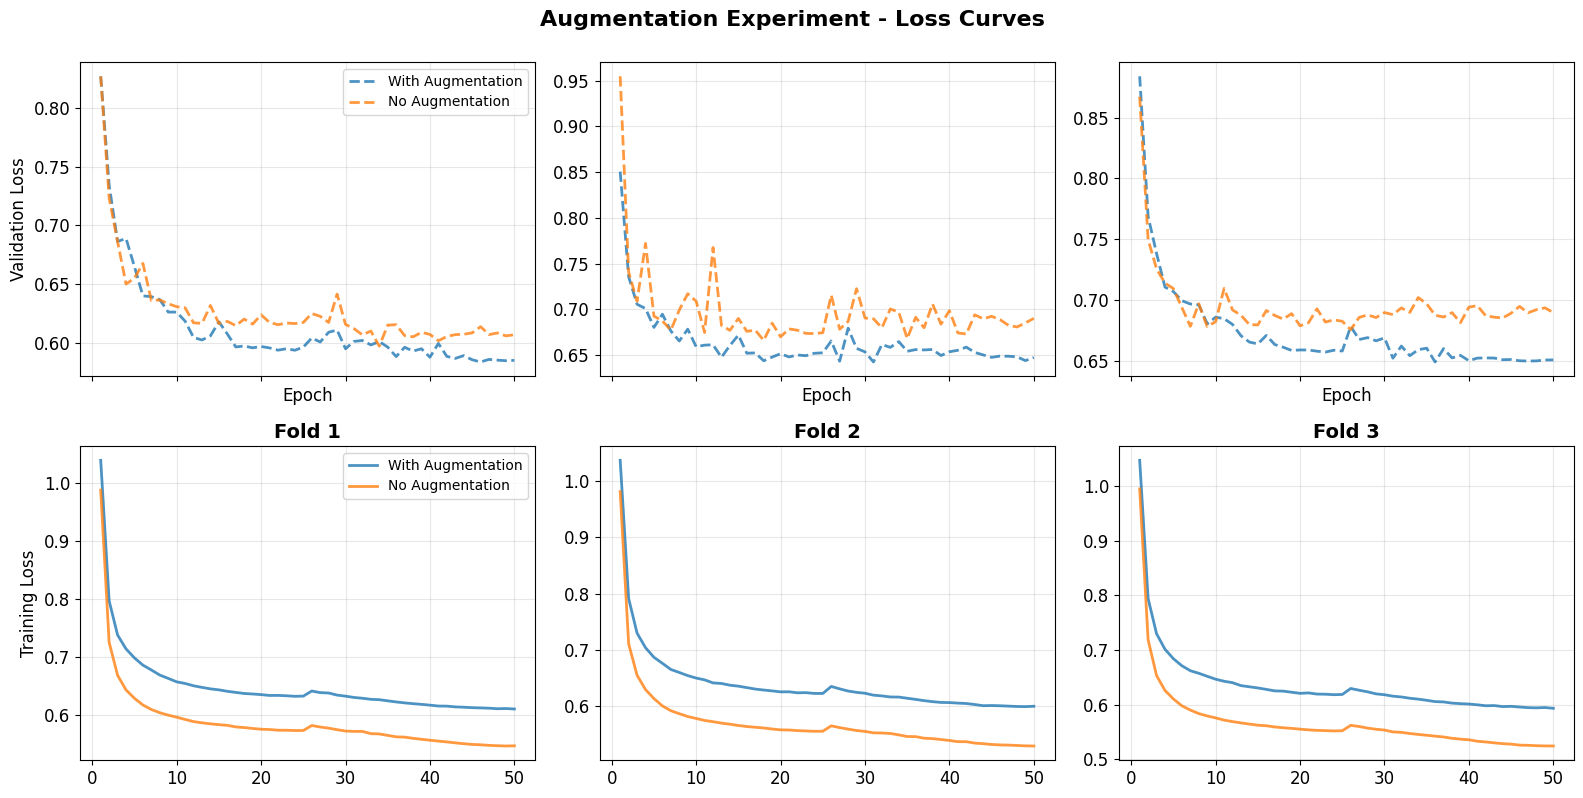

In [49]:
# Validation Loss Curves Across Folds
plot_training_curves(
    augmentation_df,
    metric_name='loss',
    ylabel='Loss',
    title='Augmentation Experiment - Loss Curves',
    figsize=(16, 8)
)

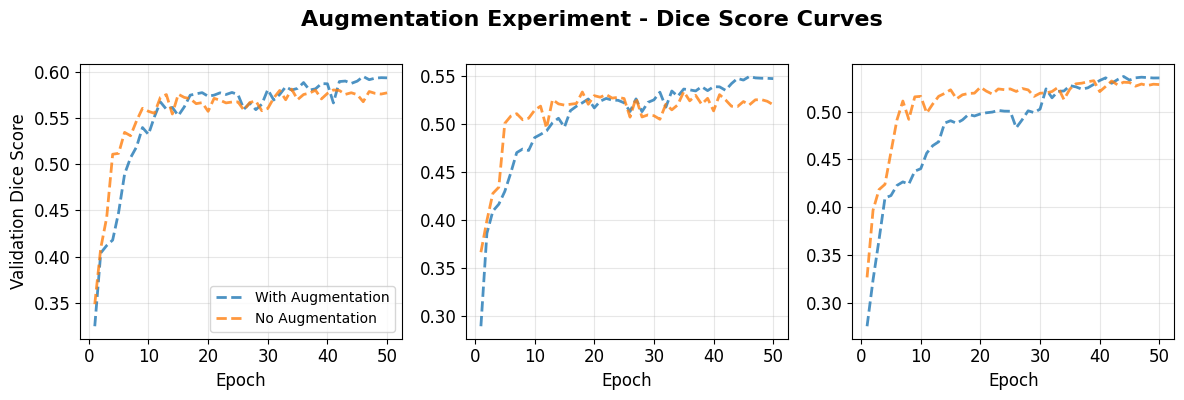

In [51]:
# Validation Dice Curves Across Folds
plot_training_curves(
    augmentation_df,
    metric_name='dice',
    ylabel='Dice Score',
    title='Augmentation Experiment - Dice Score Curves',
    figsize=(12, 4)
)

In [52]:
configs = ["No Augmentation", "With Augmentation"]
print_statistical_summary(configs, augmentation_results)

STATISTICAL SUMMARY

No Augmentation:
  Average Dice: 0.5491 ± 0.0226
  Fold 1: 0.5811 (epoch 34)
  Fold 2: 0.5340 (epoch 35)
  Fold 3: 0.5322 (epoch 39)

With Augmentation:
  Average Dice: 0.5604 ± 0.0249
  Fold 1: 0.5947 (epoch 46)
  Fold 2: 0.5498 (epoch 46)
  Fold 3: 0.5367 (epoch 44)

   BEST CONFIGURATION: With Augmentation
   Average Dice Score: 0.5604

With Augmentation:
  Improvement over baseline: +2.05%
